# Import Libraries

In [1]:
# First import the libraries to read/ treat the data

import pandas as pd
import numpy as np
import sklearn as skl
import os
import matplotlib.pyplot as plt

# Read & Preprocess Data

In [2]:
#Read the data

def converter_validations(s):
    s= "".join([e for e in s if e.isnumeric()])
    return int(s)

data = pd.read_csv( os.path.join("data","validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-semestre-2015.csv"),\
                   delimiter=";", converters = { "NB_VALD": converter_validations}  )

In [3]:
# preprocess the data
data = data.drop( columns=["CODE_STIF_TRNS","CODE_STIF_RES","CODE_STIF_ARRET","ID_REFA_LDA","CATEGORIE_TITRE"])
data = data.groupby(["JOUR","LIBELLE_ARRET"],as_index=False).sum()
data.head()

,JOUR,LIBELLE_ARRET,NB_VALD
0,2018-01-01,ABBESSES,921
1,2018-01-01,ABLON,191
2,2018-01-01,ACHERES-GRAND-CORMIER,24
3,2018-01-01,ACHERES-VILLE,628
4,2018-01-01,AEROPORT CHARLES DE GAULLE 1,3278


In [4]:
# Convert date to day number for ease of use
monthes = np.cumsum([0,31, 28 ,31,30,31,30,31,31,30,31,30])

def convert_day(jour):
    year, month,day = jour.split("-")
    return monthes[ int(month)-1] + int(day)

data.JOUR = [ convert_day(s) for s in data.JOUR]

In [5]:
data.head()

,JOUR,LIBELLE_ARRET,NB_VALD
0,1,ABBESSES,921
1,1,ABLON,191
2,1,ACHERES-GRAND-CORMIER,24
3,1,ACHERES-VILLE,628
4,1,AEROPORT CHARLES DE GAULLE 1,3278


# Fist statistical looks at the DB

In [6]:
# Number of stations
stations = np.unique(data.LIBELLE_ARRET)
print(len(stations))   #732 stations
print(stations)

732
['ABBESSES' 'ABLON' 'ACHERES-GRAND-CORMIER' 'ACHERES-VILLE'
 'AEROPORT CHARLES DE GAULLE 1' 'AEROPORT CHARLES DE GAULLE 2-TGV'
 'ALESIA' 'ALEXANDRE DUMAS' 'ALLEE DE LA TOUR RENDEZ-VOUS' 'ALMA-MARCEAU'
 'ANATOLE FRANCE' 'ANDRESY' 'ANGERVILLE' 'ANTONY' 'ANVERS'
 'ARCUEIL-CACHAN' 'ARGENTEUIL' 'ARGENTINE' 'ARPAJON' 'ARTS ET METIERS'
 'ASNIERES' 'ASSEMBLEE NATIONALE' 'ATHIS-MONS' 'AUBER'
 'AUBERGENVILLE-ELISABETHVILLE' 'AUBERVILLIERS-PANTIN (QUATRE CHEMINS)'
 'AULNAY-SOUS-BOIS' 'AUSTERLITZ' 'AUVERS-SUR-OISE'
 'AVENUE DU PRESIDENT KENNEDY' 'AVENUE EMILE ZOLA' 'AVENUE FOCH'
 'AVENUE HENRI MARTIN' 'AVRON' 'BAGNEUX' 'BAGNEUX-SUR-LOING' 'BALARD'
 'BALLANCOURT' 'BARBES-ROCHECHOUART' 'BASILIQUE DE SAINT-DENIS' 'BASTILLE'
 'BECON-LES-BRUYERES' 'BEL-AIR' 'BELLEVILLE' 'BELLEVUE'
 'BELLOY-SAINT-MARTIN' 'BERAULT' 'BERCY' 'BESSANCOURT' 'BEYNES'
 'BIBLIOTHEQUE FRANCOIS MITTERRAND' 'BIEVRES' 'BILLANCOURT'
 'BIR-HAKEIM (GRENELLE)' 'BLANC-MESNIL' 'BLANCHE' 'BOBIGNY-PABLO PICASSO'
 'BOBIGNY-PANTIN (RAYMO

In [7]:
# Select Gare du Nord station

data_gdn = data[data.LIBELLE_ARRET =='GARE DU NORD' ]
data_gdn.head()


,JOUR,LIBELLE_ARRET,NB_VALD
247,1,GARE DU NORD,29604
972,2,GARE DU NORD,78618
1699,3,GARE DU NORD,85087
2424,4,GARE DU NORD,87573
3151,5,GARE DU NORD,91845


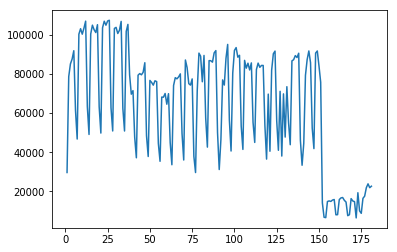

In [8]:
days = np.array(data_gdn.JOUR) 
validations = np.array(data_gdn.NB_VALD)
plt.plot(days, validations)

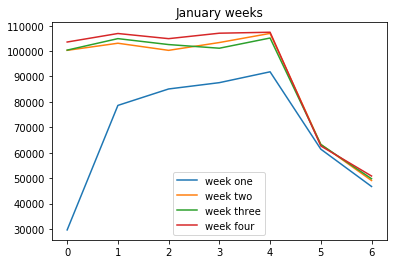

In [9]:
plt.plot(validations[:7],label="week one")
plt.plot(validations[7:14],label="week two")
plt.plot(validations[14:21],label="week three")
plt.plot(validations[21:28],label="week four")
plt.title("January weeks")
plt.legend()
plt.show()

 - We note the presence of a weekly pattern
 - Big difference with week one : due to vacation + New Year celebration

# Predicting Weekly April Validations For Gare Du Nord 

In [10]:
february = validations[31:31+28]
march = validations[31+28:31+28+28]  # for the sale on convenienve, only predict the first four weeks of march
april = validations[31+28*2:31+28*3]  

In [11]:
def test_function(predicted_april):
    predicted_april = np.array(predicted_april)
    error = np.mean(np.abs(predicted_april - april))  # Average L1 evaluation
    return error  
    

### 1. Naive approach : Copy Paste March

In [12]:
def predict_april_naive(feburary,march):
    return march

In [13]:
predicted_april_naive = predict_april_naive( february,march)
error = test_function(predicted_april_naive)
print(error)

9306.107142857143


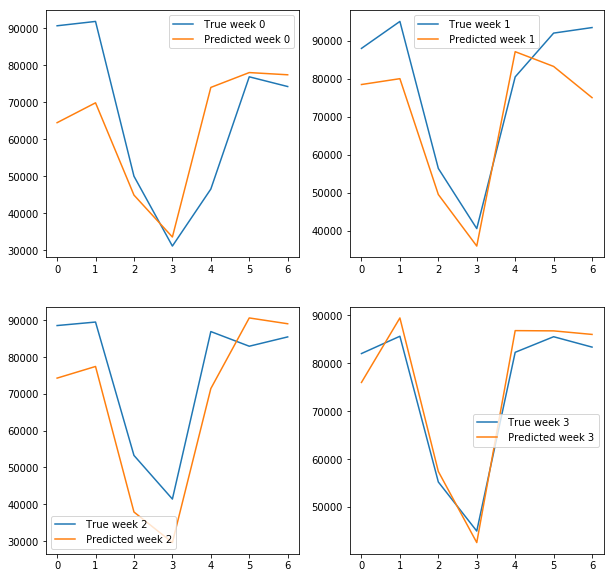

In [14]:

f,axes = plt.subplots(2,2,figsize=(10,10))
for i in range(4):
    ax= axes[i//2,i%2]
    ax.plot(april[i*7:(i+1)*7],label=" True week {}".format(i))
    ax.plot(predicted_april_naive[i*7:(i+1)*7],label=" Predicted week {}".format(i))
    ax.legend()
plt.show()

Not bad for a simple copy paste !

### 2. Average approach : Creating a typical week

In [15]:
def predict_april_avg(feburary,march):
    
    weeks_march = march.reshape( (4,-1))
    avg_week = np.mean(weeks_march,axis=0,keepdims=True)
    return np.array( [ avg_week]*4).reshape(-1)
    


In [16]:
predicted_april_avg = predict_april_avg ( february,march)
error = test_function(predicted_april_avg)
print(error)

8455.464285714286


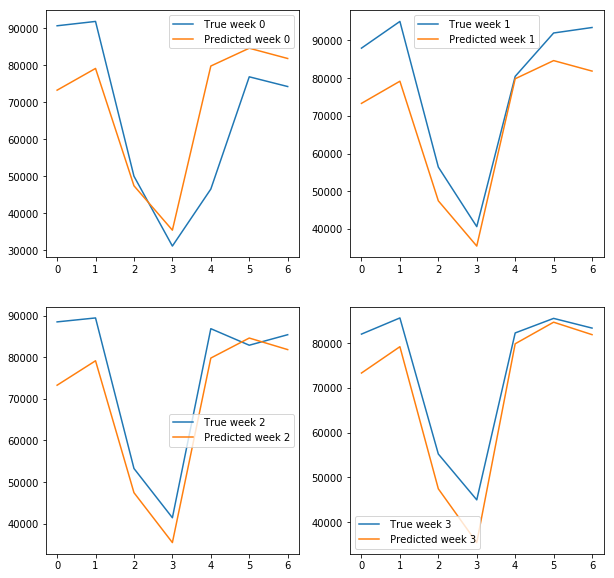

In [17]:

f,axes = plt.subplots(2,2,figsize=(10,10))
for i in range(4):
    ax= axes[i//2,i%2]
    ax.plot(april[i*7:(i+1)*7],label=" True week {}".format(i))
    ax.plot(predicted_april_avg[i*7:(i+1)*7],label=" Predicted week {}".format(i))
    ax.legend()
plt.show()

This average already reduce the error by ~10%

### 3. Trend Learning : Considering current trend + average week

In [18]:
def predict_april_trend(february,march):
    
    weeks_march = march.reshape( (4,-1))
    avg_week = np.mean(weeks_march,axis=0,keepdims=True)
    
    trend = np.array( list(february[1::7]) + list(march[1::7]) ) # Use the second day of each week to look at the trend
    
    mtrend = np.mean(trend)
    
    last_seen_trend = trend[-1]/mtrend
    
    return np.array( [ avg_week * last_seen_trend]*4).reshape(-1)
    


In [19]:
predicted_april_trend = predict_april_trend( february,march)
error = test_function(predicted_april_trend)
print(error)

6795.589970669258


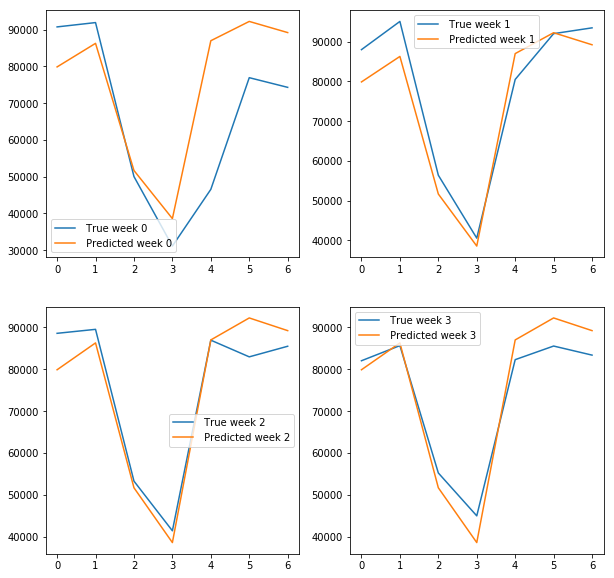

In [20]:

f,axes = plt.subplots(2,2,figsize=(10,10))
for i in range(4):
    ax= axes[i//2,i%2]
    ax.plot(april[i*7:(i+1)*7],label=" True week {}".format(i))
    ax.plot(predicted_april_trend[i*7:(i+1)*7],label=" Predicted week {}".format(i))
    ax.legend()
plt.show()

Using trend reduced the error by an additional 20 %

# Hints to Continue Improving the results

### -> Take note of special days (such as May 1st / School vacations)
### -> Learn the global trend from data, using previous years data
### -> Results from stations are not independents. Use Spatial structure of the problem